<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
!pip install wandb

In [115]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
from keras.datasets import fashion_mnist
from keras.datasets import mnist

In [116]:
wandb.login(key='')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Q1] Download the fashion-MNIST dataset and plot 1 sample image for each class

In [117]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [118]:
X_train.shape[0]

60000

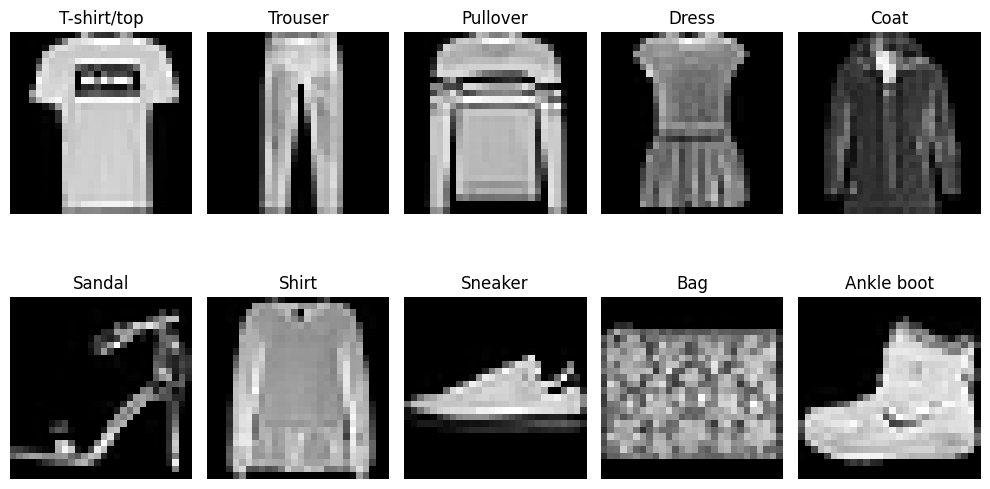

In [119]:
#wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images = []
labels = []
# Function to plot one sample image for each class
def plot_data(x, y, class_labels):
    plt.figure(figsize=(10, 6))

    for i in range(len(class_labels)):
        id = np.where(y == i)[0][0]
        image = x[id]
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(class_labels[i])
        images.append(image)
        labels.append(class_labels[i])

    plt.tight_layout()
    plt.show()

plot_data(X_train, y_train, class_labels)
# wandb.log({"Question 1 " : [wandb.Image(image , caption = f"Label: {label}") for image, label in zip(images, labels)]})
# wandb.finish()

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [121]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape input feature from 28*28 to 784*1
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [122]:
X_train.shape

(54000, 784)

In [123]:
X_val.shape

(6000, 784)

In [124]:
def initializeParam(layers, activation, weight_init = "random"):
  params = {}
  for i in range(1, len(layers)):
    if weight_init == "Xavier" or activation == "relu":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2/float(layers[i-1]))
    elif weight_init == "random":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1])

    params['b' + str(i)] = np.zeros((layers[i], 1))
  return params

In [125]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid_dev(x):
  return x * (1 - x)

def relu_dev(x):
  return np.where(x > 0, 1, 0)

def tanh_dev(x):
  return 1 - x**2

def softmax(x):
  x = np.clip(x, -700, 700)
  return np.exp(x) / np.sum(np.exp(x), axis = 0)

Q2] Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

In [126]:
def forward_prop(X, layers, params, activation):
  func = {}
  func['h0'] = X
  func['a0'] = X
  output = []
  for i in range(1, len(layers)):
    a = np.dot(params['W' + str(i)], func['h' + str(i-1)].T) + params['b' + str(i)]

    #print(params['W' + str(i)].shape, func['h' + str(i-1)].T.shape, params['b' + str(i)].shape, a.shape)

    if(i == len(layers) - 1) :
      h = softmax(a)
      output = h
    else :
      if activation == "sigmoid" :
        h = sigmoid(a)
      elif activation == "relu" :
        h = relu(a)
      elif activation == "tanh" :
        h = tanh(a)

    func['a' + str(i)] = a.T
    func['h' + str(i)] = h.T

  return output, func

Q3] Implement the backpropagation algorithm with support for the following optimisation functions

In [127]:
def back_prop(func, params, y, pred_y, L, loss_func, activation):
  m = y.size
  gradients = {}
  if loss_func == "cross_entropy" :
    dL_a = pred_y - y.T
  elif loss_func == "squared_loss" :
    dL_a = 2*(pred_y - y.T) * pred_y

  h_prev = func['h'+str(L)]
  act_dev = sigmoid_dev

  if activation == "sigmoid":
    act_dev = sigmoid_dev
  elif activation == "relu":
    act_dev = relu_dev
  elif activation == "tanh":
    act_dev = tanh_dev

  for k in range(L, -1, -1):
    dL_W = np.dot(dL_a, h_prev)
    dL_b = np.sum(dL_a, axis=1, keepdims=True)

    #print(dL_W.shape, dL_b.shape)

    dL_h = np.dot(params['W'+str(k+1)].T,  dL_a)
    dL_a = dL_h * act_dev(h_prev).T  #sigmoid (h_prev * (1- h_prev)).T

    gradients['dW' + str(k+1)] = dL_W
    gradients['db' + str(k+1)] = dL_b
    if(k-1 > -1):
      h_prev = func['h' + str(k-1)]


  return gradients

In [128]:
def sgd(params, gradients, eta, L, decay):
  for i in range(1, L):
    params['W' + str(i)] -=  eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    params['b' + str(i)] -=  eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

In [129]:
def mgd(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    history[key] = momentum * history[key] + eta * (gradients['d' + key] + decay * params[key])
    params[key] -= history[key]


In [130]:
def nag(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for i in range(1, L):
    history['W' + str(i)] = momentum * history['W' + str(i)] + eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    history['b' + str(i)] = momentum * history['b' + str(i)] + eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

    params['W' + str(i)] -= history['W' + str(i)]
    params['b' + str(i)] -= history['b' + str(i)]

In [131]:
def rmsprop(params, gradients, history, max_epochs, beta, eta, eps, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])

  for i in range(1, L):
    history['W' + str(i)] = beta * history['W' + str(i)] + (1 - beta) * gradients['dW' + str(i)]**2
    history['b' + str(i)] = beta * history['b' + str(i)] + (1 - beta) * gradients['db' + str(i)]**2

    params['W' + str(i)] -= (eta * gradients['dW' + str(i)]/(np.sqrt(history['W' + str(i)]) + eps)) + (eta * decay * params['W' + str(i)])
    params['b' + str(i)] -= (eta * gradients['db' + str(i)]/(np.sqrt(history['b' + str(i)]) + eps)) + (eta * decay * params['b' + str(i)])

In [132]:
def adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= eta * m_w_hat/(np.sqrt(v_w_hat) + eps) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= eta * m_b_hat/(np.sqrt(v_b_hat) + eps) + (eta * decay * params['b' + str(i)])


In [133]:
def nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= (eta/np.sqrt(v_w_hat + eps)) * (beta1 * m_w_hat + (1-beta1) * gradients['dW'+str(i)] / (1 - beta1**t)) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= (eta/np.sqrt(v_b_hat + eps)) * (beta1 * m_b_hat + (1-beta1) * gradients['db'+str(i)] / (1 - beta1**t)) + (eta * decay * params['b' + str(i)])

In [134]:
def compute_loss(y, y_pred, loss, epsilon=1e-10):
  if loss == "squared_loss":
    return np.sum((y - y_pred)**2)/y.shape[0]
  elif loss == "cross_entropy":
    return -np.sum(np.multiply(y, np.log(y_pred + epsilon)))/y.shape[0]

In [135]:
def loss_dev(y, y_pred, loss):
  if loss == "cross_entropy":
    return -y/y_pred
  elif loss == "squared_loss":
    return y_pred - y

In [136]:
def get_prediction(output):
  return np.argmax(output, axis=0)

def get_accuracy(prediction, Y):
  #print(prediction, Y)
  return np.sum(prediction == Y)/Y.size

def cal_confusion(prediction, Y):
  count = 0
  confusion_mat = np.zeros((10, 10))
  for i in range(len(prediction)):
    confusion_mat[prediction[i]][Y[i]] += 1
  print(confusion_mat)

In [137]:
def lookahead(params, history, momentum):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    else :
      history[key] = momentum * history[key]
    params[key] -= history[key]

In [140]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'batch_size' : {
            'values' : [16, 32, 64]
        },
        'learning_rate': {
            'values' : [1e-3, 5e-3, 1e-4]
        },
        'hidden_layers' : {
            'values' : [3, 4, 5]
        },
        'hidden_layer_size' :  {
            'values' : [32, 64, 128]
        },
        'weight_init' : {
            'values' : ['random', 'Xavier']
        },
        'weight_decay' : {
            'values' : [0, 0.005]
        },
        'optimizer' : {
            'values' : ['adam', 'nadam']
        },
        'activation' : {
            'values' : ['sigmoid', 'relu', 'tanh']
        }
    }
}

In [141]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1', entity = "cs23m009")

Create sweep with ID: 78792jrn
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_1/sweeps/78792jrn


In [142]:
def main():
  with wandb.init() as run:
    run_name = 'o_{}_a_{}_lr_{}_hl{}_bs{}_w_{}'.format(wandb.config.optimizer, wandb.config.activation, wandb.config.learning_rate, str(wandb.config.hidden_layer_size) + "_" + str(wandb.config.hidden_layers), wandb.config.batch_size, wandb.config.weight_init)
    wandb.run.name = run_name
    train(X_train, y_train, wandb.config["hidden_layer_size"], wandb.config["hidden_layers"], "cross_entropy", wandb.config["activation"], wandb.config["weight_init"], wandb.config["learning_rate"], wandb.config["epochs"], wandb.config["batch_size"], wandb.config["optimizer"], wandb.config["weight_decay"])

wandb.agent(sweep_id, function = main, count = 5)
wandb.finish()

wandb: Agent Starting Run: a8wa9gxa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.39248938673006734, Train Accuracy: 0.8568333333333333, Val Loss: 0.4110817736156954, Val Accuracy: 0.8486666666666667
Epoch 2, Train Loss: 0.35577751340959096, Train Accuracy: 0.8693518518518518, Val Loss: 0.3850086978171923, Val Accuracy: 0.8586666666666667
Epoch 3, Train Loss: 0.33364804552933985, Train Accuracy: 0.8780555555555556, Val Loss: 0.37199505969031604, Val Accuracy: 0.8651666666666666
Epoch 4, Train Loss: 0.32569301352089397, Train Accuracy: 0.8807777777777778, Val Loss: 0.3755049358004328, Val Accuracy: 0.8673333333333333
Epoch 5, Train Loss: 0.3221471394594881, Train Accuracy: 0.8816666666666667, Val Loss: 0.38048843189651355, Val Accuracy: 0.8648333333333333
Epoch 6, Train Loss: 0.3053559874495084, Train Accuracy: 0.8868333333333334, Val Loss: 0.37198660961187535, Val Accuracy: 0.8693333333333333
Epoch 7, Train Loss: 0.29762577970185744, Train Accuracy: 0.8892037037037037, Val Loss: 0.36946173596167764, Val Accuracy: 0.8725
Epoch 8, Train Loss: 0.

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▆▆▅▇████
val_loss,█▄▁▂▃▁▁▂▂▃
epoch,10
train_accuracy,0.89322
train_loss,0.28309
val_accuracy,0.87383
val_loss,0.38008


wandb: Agent Starting Run: r5um4ahv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 1.8628810158771707, Train Accuracy: 0.42498148148148146, Val Loss: 1.869494244319937, Val Accuracy: 0.4191666666666667
Epoch 2, Train Loss: 1.640403296781281, Train Accuracy: 0.44857407407407407, Val Loss: 1.6473921915644338, Val Accuracy: 0.43566666666666665
Epoch 3, Train Loss: 1.4790164961829826, Train Accuracy: 0.5314074074074074, Val Loss: 1.486012499898796, Val Accuracy: 0.52
Epoch 4, Train Loss: 1.3582191121577607, Train Accuracy: 0.5445, Val Loss: 1.3651669481149904, Val Accuracy: 0.5363333333333333
Epoch 5, Train Loss: 1.2718575037398567, Train Accuracy: 0.5638333333333333, Val Loss: 1.2789420240273652, Val Accuracy: 0.5568333333333333


epoch,▁▃▅▆█
train_accuracy,▁▂▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▂▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.56383
train_loss,1.27186
val_accuracy,0.55683
val_loss,1.27894


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vhfkd7ts with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 1.2318372454272775, Train Accuracy: 0.5785555555555556, Val Loss: 1.2556567572950774, Val Accuracy: 0.566
Epoch 2, Train Loss: 1.0356240199007662, Train Accuracy: 0.6395185185185185, Val Loss: 1.060330275717122, Val Accuracy: 0.6271666666666667
Epoch 3, Train Loss: 0.9443207941634009, Train Accuracy: 0.6714814814814815, Val Loss: 0.9799802174597502, Val Accuracy: 0.6575
Epoch 4, Train Loss: 0.8840295941827739, Train Accuracy: 0.6866296296296296, Val Loss: 0.9247177609052831, Val Accuracy: 0.6753333333333333
Epoch 5, Train Loss: 0.8453127339251846, Train Accuracy: 0.7004259259259259, Val Loss: 0.8877933725264718, Val Accuracy: 0.6873333333333334
Epoch 6, Train Loss: 0.8126619317376935, Train Accuracy: 0.7085925925925926, Val Loss: 0.8458676302195619, Val Accuracy: 0.6985
Epoch 7, Train Loss: 0.7886887844962032, Train Accuracy: 0.7157962962962963, Val Loss: 0.8226190815513507, Val Accuracy: 0.7075
Epoch 8, Train Loss: 0.769157264572942, Train Accuracy: 0.721240740740

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.73359
train_loss,0.73483
val_accuracy,0.7255
val_loss,0.76657


wandb: Agent Starting Run: g3g86v0k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.5678692321746799, Train Accuracy: 0.814037037037037, Val Loss: 0.5752081941417382, Val Accuracy: 0.8093333333333333
Epoch 2, Train Loss: 0.5030197585480195, Train Accuracy: 0.8296481481481481, Val Loss: 0.5091396155937664, Val Accuracy: 0.8215
Epoch 3, Train Loss: 0.4714501046256315, Train Accuracy: 0.8384814814814815, Val Loss: 0.4769792998205416, Val Accuracy: 0.8291666666666667
Epoch 4, Train Loss: 0.4512093954621938, Train Accuracy: 0.844037037037037, Val Loss: 0.45648667707800905, Val Accuracy: 0.8335
Epoch 5, Train Loss: 0.4365001026429779, Train Accuracy: 0.8488148148148148, Val Loss: 0.44173798791019986, Val Accuracy: 0.8396666666666667
Epoch 6, Train Loss: 0.4250007167717964, Train Accuracy: 0.8522962962962963, Val Loss: 0.43035039316652757, Val Accuracy: 0.8448333333333333
Epoch 7, Train Loss: 0.4155709683734728, Train Accuracy: 0.8553333333333333, Val Loss: 0.42114610113236, Val Accuracy: 0.8486666666666667
Epoch 8, Train Loss: 0.40757588564972086, Tra

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.86137
train_loss,0.39448
val_accuracy,0.85317
val_loss,0.40119


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4o7cc4qa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.8889764323005703, Train Accuracy: 0.6673518518518519, Val Loss: 0.9306375844613065, Val Accuracy: 0.65
Epoch 2, Train Loss: 0.7705836983464163, Train Accuracy: 0.7008888888888889, Val Loss: 0.8191729178359947, Val Accuracy: 0.6853333333333333
Epoch 3, Train Loss: 0.7177630832822605, Train Accuracy: 0.7216296296296296, Val Loss: 0.7646430006039511, Val Accuracy: 0.7055
Epoch 4, Train Loss: 0.680781603554085, Train Accuracy: 0.7358148148148148, Val Loss: 0.7265009140524346, Val Accuracy: 0.7203333333333334
Epoch 5, Train Loss: 0.646262596528213, Train Accuracy: 0.7505185185185185, Val Loss: 0.6910594183445177, Val Accuracy: 0.7351666666666666
Epoch 6, Train Loss: 0.6184811183053591, Train Accuracy: 0.7622407407407408, Val Loss: 0.6633893243019188, Val Accuracy: 0.7455
Epoch 7, Train Loss: 0.5950515349478475, Train Accuracy: 0.7715925925925926, Val Loss: 0.6476297772445292, Val Accuracy: 0.7551666666666667
Epoch 8, Train Loss: 0.5769495831105869, Train Accuracy: 0.7

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.79006
train_loss,0.54342
val_accuracy,0.7695
val_loss,0.59722


In [138]:
def train(X_train, y_train, hidden_layer_size, no_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch_size, optimizer, weight_decay):
  input_neurons = X_train.shape[1]
  hidden_neurons = hidden_layer_size #wandb.config["hidden_layer_size"]
  num_layers = no_layers #wandb.config["hidden_layers"]
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_train_onehot = np.eye(10)[y_train]
  y_val_onehot = np.eye(10)[y_val]
  loss_function = loss_func #"cross_entropy"
  activation = activation_func #wandb.config["activation"]
  weight_init = wt_init #wandb.config["weight_init"]

  params = initializeParam(layers, activation, weight_init)
  eta = learning_rate #wandb.config["learning_rate"]
  max_epochs = epochs #wandb.config["epochs"]
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch_size #wandb.config["batch_size"]
  optimizer = optimizer #wandb.config["optimizer"]
  decay = weight_decay #wandb.config["weight_decay"]
  final_res = []
  history = {}
  moment = {}

  for epoch in range(max_epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_train[i : i + batch_size]
      y_batch = y_train_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

    y_predict, func = forward_prop(X_train, layers, params, activation)
    train_loss = compute_loss(y_train_onehot, y_predict.T, loss_function)
    train_accuracy = get_accuracy(get_prediction(y_predict), y_train)

    y_val_predict, _ = forward_prop(X_val, layers, params, activation)
    val_loss = compute_loss(y_val_onehot, y_val_predict.T, loss_function)
    val_accuracy = get_accuracy(get_prediction(y_val_predict), y_val)

    #final_res = get_prediction(y_predict)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss' : val_loss, 'val_accuracy' : val_accuracy, 'epoch': epoch+1})

Q7] For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix

In [139]:
def confusion_matrix(X_test, y_test, hidden_layer_size, hidden_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch, opt_func, wt_decay):
  #wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
  input_neurons = X_test.shape[1]
  hidden_neurons = hidden_layer_size
  num_layers = hidden_layers
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_test_onehot = np.eye(10)[y_test]
  loss_function = loss_func
  activation = activation_func
  weight_init = wt_init

  params = initializeParam(layers, activation, weight_init)
  eta = learning_rate
  max_epochs = epochs
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch
  optimizer = opt_func
  decay = wt_decay
  final_res = []
  history = {}
  moment = {}
  print(layers)

  for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_test[i : i + batch_size]
      y_batch = y_test_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

  y_predict, func = forward_prop(X_test, layers, params, activation)
  test_loss = compute_loss(y_test_onehot, y_predict.T, loss_function)
  test_accuracy = get_accuracy(get_prediction(y_predict), y_test)
  cal_confusion(get_prediction(y_predict), y_test)
  #wandb.log({"Confusion Matrix " : wandb.sklearn.plot_confusion_matrix(y_test, get_prediction(y_predict), class_labels)})
  print(test_accuracy, test_loss)
  #wandb.finish()

In [144]:
confusion_matrix(X_test, y_test, 128, 5, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)

[784, 128, 128, 128, 10]
[[859.   2.  11.  48.   0.   1.  95.   0.   2.   0.]
 [  0. 978.   0.   7.   0.   0.   0.   0.   1.   0.]
 [  6.   0. 630.  15.  18.   0.  40.   0.   0.   0.]
 [  4.  13.   3. 778.   2.   0.   3.   0.   1.   0.]
 [  5.   4. 319.  92. 964.   0. 190.   0.   4.   0.]
 [  0.   0.   0.   0.   0. 993.   0.  38.   1.   3.]
 [120.   2.  36.  59.  16.   0. 666.   0.   2.   0.]
 [  0.   0.   0.   0.   0.   2.   0. 941.   1.  27.]
 [  6.   1.   1.   1.   0.   1.   6.   3. 988.   1.]
 [  0.   0.   0.   0.   0.   3.   0.  18.   0. 969.]]
0.8766 0.32912227793799054


Q8]  Compare the cross entropy loss with the squared error loss.

In [30]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 5, "cross_entropy", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.34968013850677326, Train Accuracy: 0.8732037037037037, Val Loss: 0.3649177274042961, Val Accuracy: 0.8661666666666666
Epoch 2, Train Loss: 0.31067664135627326, Train Accuracy: 0.8878703703703704, Val Loss: 0.33827613279826496, Val Accuracy: 0.8765
Epoch 3, Train Loss: 0.2872877015473446, Train Accuracy: 0.8946111111111111, Val Loss: 0.3244909549754149, Val Accuracy: 0.8808333333333334
Epoch 4, Train Loss: 0.27171171959065976, Train Accuracy: 0.9002407407407408, Val Loss: 0.3171516898726329, Val Accuracy: 0.884
Epoch 5, Train Loss: 0.25998473068617367, Train Accuracy: 0.9036851851851851, Val Loss: 0.3128222839706389, Val Accuracy: 0.8848333333333334
Epoch 6, Train Loss: 0.2501839163377341, Train Accuracy: 0.9068888888888889, Val Loss: 0.3099716089255395, Val Accuracy: 0.8863333333333333
Epoch 7, Train Loss: 0.24147246603875538, Train Accuracy: 0.9100185185185186, Val Loss: 0.30796182789306137, Val Accuracy: 0.8888333333333334
Epoch 8, Train Loss: 0.233526678828162

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.91841
train_loss,0.21935
val_accuracy,0.8915
val_loss,0.30496


In [31]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 5, "squared_loss", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.1895317258766944, Train Accuracy: 0.8666666666666667, Val Loss: 0.19878711410672123, Val Accuracy: 0.86
Epoch 2, Train Loss: 0.17288250203127786, Train Accuracy: 0.8789444444444444, Val Loss: 0.18566190840892216, Val Accuracy: 0.8701666666666666
Epoch 3, Train Loss: 0.16351088934973743, Train Accuracy: 0.8866296296296297, Val Loss: 0.1800351287787599, Val Accuracy: 0.8758333333333334
Epoch 4, Train Loss: 0.15594158674453087, Train Accuracy: 0.8918148148148148, Val Loss: 0.17587407286795598, Val Accuracy: 0.879
Epoch 5, Train Loss: 0.14956173774431802, Train Accuracy: 0.895537037037037, Val Loss: 0.1729058948017992, Val Accuracy: 0.8806666666666667
Epoch 6, Train Loss: 0.1443877835207228, Train Accuracy: 0.8989074074074074, Val Loss: 0.1710983423283844, Val Accuracy: 0.8801666666666667
Epoch 7, Train Loss: 0.14028989477774356, Train Accuracy: 0.901425925925926, Val Loss: 0.16994347107136776, Val Accuracy: 0.8838333333333334
Epoch 8, Train Loss: 0.13718788331504586

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇█▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90559
train_loss,0.13278
val_accuracy,0.88533
val_loss,0.16856


Q10] Check for MNIST Data (before running make sure to load data above)

In [111]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 3, "cross_entropy", "tanh", "Xavier", 0.001, 5, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.14378545374288945, Train Accuracy: 0.9586851851851852, Val Loss: 0.15298401406180698, Val Accuracy: 0.9531666666666667
Epoch 2, Train Loss: 0.10628864412125563, Train Accuracy: 0.9696851851851852, Val Loss: 0.1227309313094423, Val Accuracy: 0.9636666666666667
Epoch 3, Train Loss: 0.08673899171103037, Train Accuracy: 0.9752037037037037, Val Loss: 0.10851279848895878, Val Accuracy: 0.9688333333333333
Epoch 4, Train Loss: 0.07318289494347716, Train Accuracy: 0.9793518518518518, Val Loss: 0.09911559888299047, Val Accuracy: 0.9713333333333334
Epoch 5, Train Loss: 0.06270504213860892, Train Accuracy: 0.9829074074074075, Val Loss: 0.09215187625632895, Val Accuracy: 0.9721666666666666


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.98291
train_loss,0.06271
val_accuracy,0.97217
val_loss,0.09215


In [112]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 3, "cross_entropy", "relu", "Xavier", 0.001, 5, 32, "adam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.11264834960997817, Train Accuracy: 0.967037037037037, Val Loss: 0.12752529181748368, Val Accuracy: 0.963
Epoch 2, Train Loss: 0.07365138736743455, Train Accuracy: 0.9782222222222222, Val Loss: 0.09582821148187111, Val Accuracy: 0.9716666666666667
Epoch 3, Train Loss: 0.055162541943479144, Train Accuracy: 0.9837962962962963, Val Loss: 0.08435685712372423, Val Accuracy: 0.9755
Epoch 4, Train Loss: 0.04262825148690485, Train Accuracy: 0.9878333333333333, Val Loss: 0.0783274239585031, Val Accuracy: 0.9773333333333334
Epoch 5, Train Loss: 0.03429634228898798, Train Accuracy: 0.9902962962962963, Val Loss: 0.07570144724755246, Val Accuracy: 0.9765


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.9903
train_loss,0.0343
val_accuracy,0.9765
val_loss,0.0757


In [113]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 3, "cross_entropy", "sigmoid", "Xavier", 0.005, 5, 32, "adam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.12310219230150632, Train Accuracy: 0.9629814814814814, Val Loss: 0.13468645345661764, Val Accuracy: 0.9591666666666666
Epoch 2, Train Loss: 0.08295747920065205, Train Accuracy: 0.9749629629629629, Val Loss: 0.10421318320977355, Val Accuracy: 0.9673333333333334
Epoch 3, Train Loss: 0.06277356900364672, Train Accuracy: 0.9810185185185185, Val Loss: 0.09255504370851347, Val Accuracy: 0.9713333333333334
Epoch 4, Train Loss: 0.04897462987790104, Train Accuracy: 0.9851666666666666, Val Loss: 0.08659464226986714, Val Accuracy: 0.9733333333333334
Epoch 5, Train Loss: 0.036642927444670306, Train Accuracy: 0.9891296296296296, Val Loss: 0.0815424229500368, Val Accuracy: 0.9753333333333334


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
epoch,5
train_accuracy,0.98913
train_loss,0.03664
val_accuracy,0.97533
val_loss,0.08154
